# `interp-acf` demo

Generate time series fluxes with two oscillation periods, and missing data:

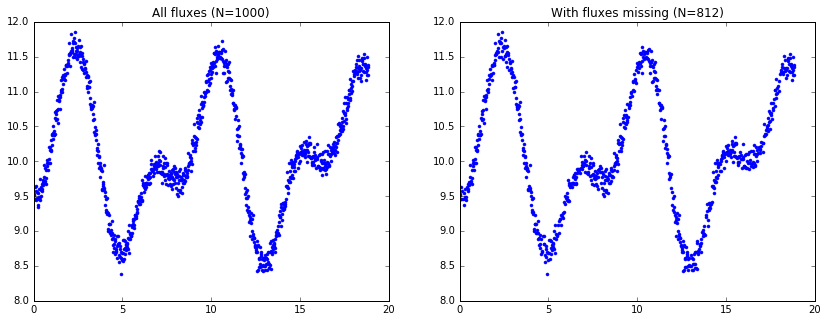

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Make flux time-series with random noise, and 
# two periodic oscillations, one 70% the amplitude
# of the other:
np.random.seed(42)
n_points = 1000
primary_period = 2.5*np.pi
secondary_period = 1.3*np.pi
all_times = np.linspace(0, 6*np.pi, n_points)
all_fluxes = 10 + (0.1*np.random.randn(len(all_times)) + 
                   np.sin(2*np.pi/primary_period * all_times) + 
                   0.7*np.cos(2*np.pi/secondary_period * (all_times - 2.5)))

# Remove some fluxes, times from those data: 
n_points_missing = 200  # This number is approximate
missing_indices = np.unique(np.random.randint(0, n_points, 
                                              size=n_points_missing))
mask = list(set(np.arange(len(all_times))).difference(set(missing_indices)))
times_incomplete = all_times[mask]
fluxes_incomplete = all_fluxes[mask]

# Plot these fluxes before and after data are removed:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(all_times, all_fluxes, '.')
ax[0].set(title='All fluxes (N={0})'.format(len(all_fluxes)))
ax[1].plot(times_incomplete, fluxes_incomplete, '.')
ax[1].set(title='With fluxes missing (N={0})'.format(len(fluxes_incomplete)))
plt.show()

Now we'll use two `interpacf` methods on these simulated fluxes: 

* `interpacf.interpolated_acf` will interpolate over the missing fluxes and compute the autocorrelation function. Don't forget to subtract the flux its mean!

* `interpacf.dominant_period` returns the lag with the highest peak in the smoothed autocorrelation function. The default smoothing kernel matches that of [McQuillan, Aigrain & Mazeh (2013)](http://adsabs.harvard.edu/abs/2013MNRAS.432.1203M)



Actual dominant period: 7.854
Detected dominant period: 7.962
Difference: -0.014%


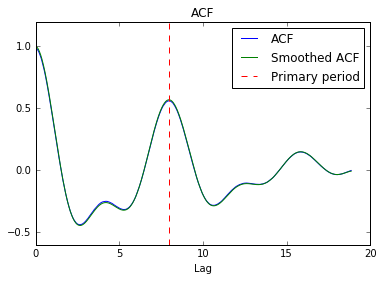

In [2]:
from interpacf import interpolated_acf, dominant_period

# Need zero-mean fluxes: 
fluxes_incomplete -= np.mean(fluxes_incomplete)

# Compute autocorrelation function
lag, acf = interpolated_acf(times_incomplete, fluxes_incomplete)

# Find dominant period in autocorrelation function
detected_period = dominant_period(lag, acf, plot=True)

print("Actual dominant period: {0:.3f}\nDetected dominant period: "
      "{1:.3f}\nDifference: {2:.3f}%"
      .format(primary_period, detected_period, 
              (primary_period - detected_period)/primary_period))